# PREPROCESS

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import keras.backend as K
import keras
import gc
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers

In [2]:
import keras

In [3]:
# Loading the training data
train_df = pd.read_csv('train/train_set.csv', index_col="Id")
labels = train_df.columns
train_df["img"] = [np.load('train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_df["seg"] = [np.load('train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
print("The training set contains {} examples.".format(len(train_df)))

The training set contains 749 examples.


In [4]:
# Loading the test data
test_df = pd.read_csv('test/test_set.csv', index_col="Id")
test_df["img"] = [np.load('test/img/test_{}.npy'.format(idx)) for idx, _ in test_df.iterrows()]
test_df["seg"] = [-1 * np.ones(img.shape[:2], dtype=np.int8) for img in test_df["img"]]
print("The test set contains {} examples.".format(len(test_df)))


The test set contains 750 examples.


In [5]:
#take first 20 columns the values of 0 and 1 of the dataframe as labels
labels_df = train_df.iloc[:, :20]
train_labels = labels_df.values

In [6]:
# Define a function to resize images
def resize_images(img_series, size=(224, 224)):
    return img_series.apply(lambda img: cv2.resize(img, size))

# Resize and convert the images to a numpy array
train_images = np.stack(resize_images(train_df["img"]).values)
test_images = np.stack(resize_images(test_df["img"]).values)


In [7]:

# Divide full training set into training and validation set:

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.1, random_state=0)

In [8]:
# Normalization
print(np.max(X_train))
X_train = X_train / 255
X_val  = X_val / 255
print(np.max(X_train))

255
1.0


In [9]:
# Creating class weights for the weighted loss
weights = np.empty([20, 2])
for i in range(20):
    weights[i] = compute_class_weight(class_weight="balanced",
                               classes=np.array([0, 1]),
                               y=y_train[:, i])
weights = weights.astype(np.float32)
print(weights)

[[ 0.53492063  7.659091  ]
 [ 0.52492213 10.53125   ]
 [ 0.5400641   6.74      ]
 [ 0.53492063  7.659091  ]
 [ 0.5298742   8.868421  ]
 [ 0.5265625   9.911765  ]
 [ 0.54530746  6.017857  ]
 [ 0.53154576  8.425     ]
 [ 0.54530746  6.017857  ]
 [ 0.5224806  11.620689  ]
 [ 0.53154576  8.425     ]
 [ 0.52904236  9.1081085 ]
 [ 0.5307087   8.641026  ]
 [ 0.53322786  8.023809  ]
 [ 0.6877551   1.8315217 ]
 [ 0.53154576  8.425     ]
 [ 0.5184615  14.041667  ]
 [ 0.53238547  8.219512  ]
 [ 0.52738655  9.6285715 ]
 [ 0.53492063  7.659091  ]]


In [10]:
# Weighed loss function
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss

In [11]:
# F1 metric
def get_f1(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall + K.epsilon())
  return f1_val

In [12]:
## WARNING: deletes model and everything
# I run this to free up my memory after running a model
from keras import backend as K
K.clear_session()
gc.collect()
del model

NameError: name 'model' is not defined

In [13]:
# Labels as floet for calculation in the weighted loss
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)


# MODEL

In [14]:
# MODEL PARAMETERS
OPT = keras.optimizers.Adam(learning_rate=0.0001)
# OPT = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
EPOCHS = 50
BATCH_SIZE = 32
NAME = "/Users/thibaultheintz/Documents/GitHub/Computer_Vision_Group_Assignment_2/models/InceptionResNetV2_augmented.h5"

In [20]:
# saving best weights based on the F1 score
save_best = ModelCheckpoint(NAME, monitor='val_get_f1', verbose=0, 
                              save_best_only=True, mode='max', save_freq="epoch")


In [15]:
# Creating data augmentation generator for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

validation_datagen = ImageDataGenerator()

In [16]:
# Importing the pretrained model of choice
from keras.applications import InceptionResNetV2
# from keras.applications import VGG16

In [17]:
# MODEL

base_model = InceptionResNetV2(include_top=False,
                                      weights="imagenet",     # "imagenet" when transfer learning
                                      input_shape=(224, 224, 3),
                                      pooling = "avg"
                                      )
x = base_model.output
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)

predictions = Dense(20, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

# TRAINING

In [ ]:
# Freezing pretrained layers + Compiling model

# FALSE when transfer learning
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=OPT, loss=get_weighted_loss(weights), metrics=["accuracy", get_f1])
# For recall and precision metrics
# model.compile(optimizer=OPT, loss=get_weighted_loss(weights), metrics=["accuracy", tf.keras.metrics.Precision(name='Precision'), 
#                        tf.keras.metrics.Recall(name='Recall')])

In [ ]:
# TRAINING (the fully connected added layers)

history = model.fit(train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data = validation_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE),
                    shuffle=True,
                    callbacks=[save_best]
                    )

In [28]:
# Plot loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [ ]:
# Plot accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Plot F1 score
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
epochs = range(1, len(f1) + 1)
plt.plot(epochs, f1, 'y', label='Training F1')
plt.plot(epochs, val_f1, 'r', label='Validation F1')
plt.title('Training and validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()
plt.show()

In [ ]:
# When using the precision and recall metrics

# Plot precision
precision = history.history['Precision']
val_precision = history.history['val_Precision']
epochs = range(1, len(precision) + 1)
plt.plot(epochs, precision, 'y', label='Training precision')
plt.plot(epochs, val_precision, 'r', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [ ]:
# When using the precision and recall metrics

# Plot recall
recall = history.history['Recall']
val_recall = history.history['val_Recall']
epochs = range(1, len(recall) + 1)
plt.plot(epochs, recall, 'y', label='Training recall')
plt.plot(epochs, val_recall, 'r', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

3/3 [==============================] - 3s 746ms/step


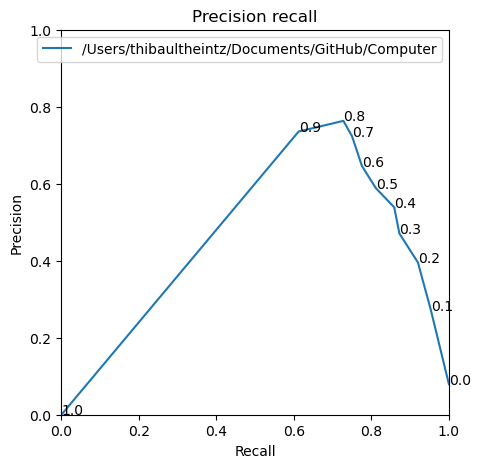

In [29]:
# Plot recall-precision trade-off
# Used to determine the threshold (manually)

from sklearn.metrics import f1_score, precision_score, recall_score

fig, ax = plt.subplots(figsize= (5,5))
ax.set_title("Precision recall")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
ax.set_xlim(xmin=0, xmax=1)
ax.set_ylim(ymin=0, ymax=1)

x = []
y = []
for threshold in np.arange(0, 1.1, 0.1):
  y_pred_val = model.predict(X_val)
  y_pred_val[y_pred_val>=threshold] = 1
  y_pred_val[y_pred_val<threshold] = 0
  p = precision_score(y_val, y_pred_val, average='samples', zero_division=0)
  r = recall_score(y_val, y_pred_val, average='samples')
  ax.annotate(str(round(threshold,2)), (r, p))
  x.append(r)
  y.append(p)
  
ax.plot(x, y)
ax.lines[-1].set_label(NAME.split("_")[0])

plt.legend(loc="upper right")
plt.show()

In [31]:
# Recall - Precision - F1-score based on threshold
# F1-scores for each class


# SET THE THRESHOLD
threshold = 0.70



print(f'\n-------- Metrics for Pretrained {NAME.split("_")[0]}:---------\n ')

y_pred_val = model.predict(X_val)

y_pred_val[y_pred_val>=threshold] = 1
y_pred_val[y_pred_val<threshold] = 0

print('Precision: ', precision_score(y_val, y_pred_val, average='samples', zero_division=0)) 
print('Recall: ', recall_score(y_val, y_pred_val, average='samples')) 
print('F1-score: ', f1_score(y_val, y_pred_val, average='samples'), '\n') 

print('Per class F1 score: ')
f1_scores = f1_score(y_val, y_pred_val, average=None)
for i in range(len(f1_scores)):
  print(list(sorted(labels))[i], round(f1_scores[i],2))


-------- Metrics for Pretrained /Users/thibaultheintz/Documents/GitHub/Computer:---------
 
3/3 [==============================] - 2s 715ms/step
Precision:  0.7233333333333334
Recall:  0.75
F1-score:  0.6973544973544973 

Per class F1 score: 
aeroplane 0.86
bicycle 0.8
bird 0.57
boat 0.73
bottle 0.62
bus 0.75
car 0.63
cat 0.89
chair 0.64
cow 0.5
diningtable 0.56
dog 0.5
horse 0.86
motorbike 0.89
person 0.72
pottedplant 0.5
sheep 0.75
sofa 0.2
train 1.0
tvmonitor 0.55


# INFERENCE

In [18]:
# Load the model if it was not trained
# model.load_weights("/Users/thibaultheintz/Documents/GitHub/Computer_Vision_Group_Assignment_2/models/InceptionResNetV2_augmented.h5")
# Load the pre-trained model with custom loss function and metric function
model = load_model("/Users/thibaultheintz/Documents/GitHub/Computer_Vision_Group_Assignment_2/models/InceptionResNetV2_augmented.h5", 
                   custom_objects={'weighted_loss': get_weighted_loss(weights),
                                   'get_f1': get_f1})



NameError: name 'load_model' is not defined

In [19]:
# Predictions on validation set

preds = model.predict(X_val)


# Using random images from validation set, change numb to specific number if wanted
numb = np.random.randint(0, len(X_val))


print(f"Predicted class probabilities: {preds[numb]}")
print(f"Ground truth: {y_val[numb]}")
# result = [num if num > 0.3 else 0 for num in preds[numb]]
# print(result)

mask = [1 if num > threshold else 0 for num in preds[numb]]
max_class = lbls[np.argmax(preds[numb])]
true_idx = np.argwhere(y_val[numb] == 1).flatten()
true_classes = []
for idx in true_idx:
    true_classes.append(lbls[idx])

c = y_val[numb] * np.array(preds[numb])

plt.imshow(X_val[numb])
plt.title(" - ".join([lbl for i, lbl in enumerate(lbls) if mask[i] == 1]))
plt.text(100, 25, f"MAX: {max_class}, {np.format_float_positional(np.max(preds[numb]), precision=2)}", color="red", fontsize=15)
plt.text(100, 50, f"CORRECT: {' '.join(true_classes)}", color="blue", fontsize=15)
plt.text(100, 75, f"prob: {'   '.join([np.format_float_positional(score, precision=2) for score in c[np.nonzero(c)]])}", color="blue", fontsize=15)

2024-05-20 14:13:04.232131: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 [==============================] - 4s 932ms/step
Predicted class probabilities: [0.45377028 0.51106524 0.7747188  0.23420228 0.6165689  0.73613584
 0.8604623  0.5078069  0.6970531  0.6350437  0.7402389  0.72843176
 0.84109354 0.29526857 0.39610806 0.23442252 0.2611432  0.8336295
 0.58917534 0.51104504]
Ground truth: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


NameError: name 'threshold' is not defined

# Aversarial attack

In [20]:
next(train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE))[1].shape

(32, 20)

In [21]:
def create_adversarial_pattern(model, input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = tf.keras.losses.categorical_crossentropy(input_label, prediction)
    
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

# Generate adversarial images
def generate_adversarial_images(model, images, labels, epsilon=0.01):
    adversarial_images = []
    for i in range(len(images)):
        image = tf.convert_to_tensor(images[i:i+1], dtype=tf.float32)
        label = tf.convert_to_tensor(labels[i:i+1], dtype=tf.float32)
        
        with tf.GradientTape() as tape:
            tape.watch(image)
            prediction = model(image)
            loss = tf.keras.losses.categorical_crossentropy(label, prediction)
        
        gradient = tape.gradient(loss, image)
        signed_grad = tf.sign(gradient)
        perturbed_image = image + epsilon * signed_grad
        
        # Clip the pixel values to valid range
        perturbed_image = tf.clip_by_value(perturbed_image, 0.0, 1.0)  # Assuming images are normalized in [0, 1] range
        
        adversarial_images.append(perturbed_image.numpy()[0])
    
    return np.array(adversarial_images)

# Data generator
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator()

# Get a batch of data
data_generator = validation_datagen.flow(X_train, y_train, batch_size=32)
images, labels = next(data_generator)

# Generate adversarial images
adversarial_images = generate_adversarial_images(model, images, labels, epsilon=0.01)

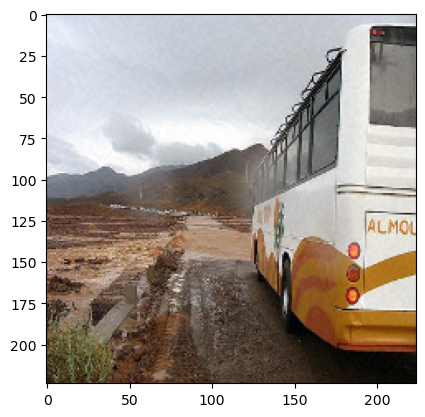

In [104]:
plt.imshow(adversarial_images[0])

1/1 [==============================] - 0s 82ms/step


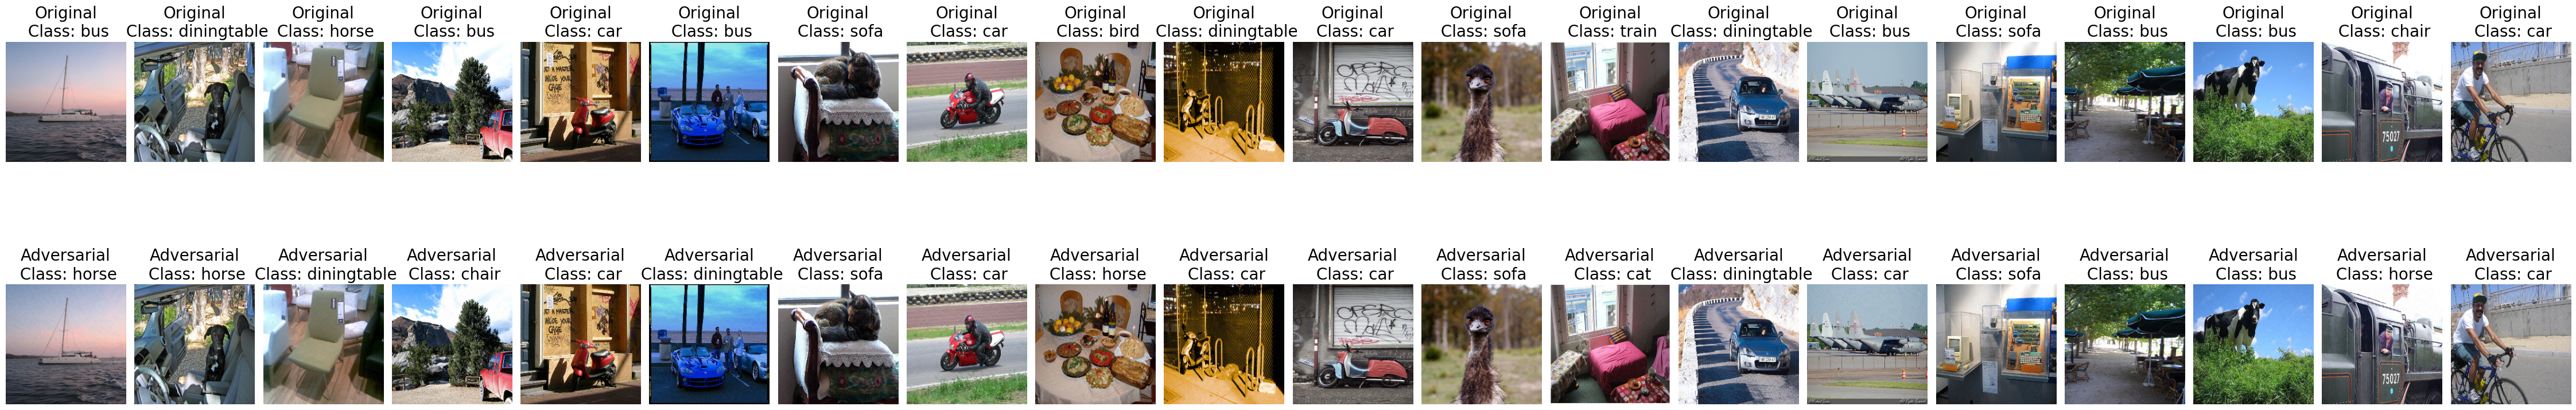

In [22]:
def display_images_with_predictions(model, original_images, adversarial_images, class_names, num_images=5):
    plt.figure(figsize=(45, 10))
    for i in range(num_images):
        # Original image
        original_prediction = model.predict(np.expand_dims(original_images[i], axis=0))
        original_class_index = np.argmax(original_prediction)
        original_class_name = class_names[original_class_index]
        
        plt.subplot(2, num_images, i+1)
        plt.imshow(original_images[i])
        plt.title(f"Original\n Class: {original_class_name}", fontsize=20)
        plt.axis('off')
        
        # Adversarial image
        adversarial_prediction = model.predict(np.expand_dims(adversarial_images[i], axis=0))
        adversarial_class_index = np.argmax(adversarial_prediction)
        adversarial_class_name = class_names[adversarial_class_index]
        
        plt.subplot(2, num_images, i+1+num_images)
        plt.imshow(adversarial_images[i])
        plt.title(f"Adversarial\n Class: {adversarial_class_name}", fontsize=20)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
class_names = [ "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", 
               "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", 
               "sheep", "sofa", "train", "tvmonitor"]
# Display the first 5 images and their adversarial counterparts
display_images_with_predictions(model, images, adversarial_images,class_names=class_names, num_images=20)

In [115]:
def create_adversarial_pattern_bim(model, input_image, input_label, epsilon=0.01, epsilon_iter=0.005, num_steps=10):
    perturbed_image = tf.identity(input_image)

    for _ in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(perturbed_image)
            prediction = model(perturbed_image)
            loss = tf.keras.losses.categorical_crossentropy(input_label, prediction)

        gradient = tape.gradient(loss, perturbed_image)
        signed_grad = tf.sign(gradient)
        perturbed_image = perturbed_image + epsilon_iter * signed_grad
        perturbed_image = tf.clip_by_value(perturbed_image, input_image - epsilon, input_image + epsilon)
        perturbed_image = tf.clip_by_value(perturbed_image, 0.0, 1.0)  # Clip to valid range

    return perturbed_image - input_image

# Generate adversarial images using Basic Iterative Method (BIM)
def generate_adversarial_images_bim(model, images, labels, epsilon=0.01, epsilon_iter=0.005, num_steps=10):
    adversarial_images = []

    for i in range(len(images)):
        image = tf.convert_to_tensor(images[i:i+1], dtype=tf.float32)
        label = tf.convert_to_tensor(labels[i:i+1], dtype=tf.float32)
        perturbations = create_adversarial_pattern_bim(model, image, label, epsilon, epsilon_iter, num_steps)
        adversarial_image = image + perturbations
        adversarial_image = tf.clip_by_value(adversarial_image, 0.0, 1.0)  # Clip to valid range
        adversarial_images.append(adversarial_image.numpy()[0])

    return np.array(adversarial_images)

# Generate adversarial images using BIM
adversarial_images_bim = generate_adversarial_images_bim(model, images, labels, epsilon=0.08, epsilon_iter=0.05, num_steps=30)


1/1 [==============================] - 0s 85ms/step


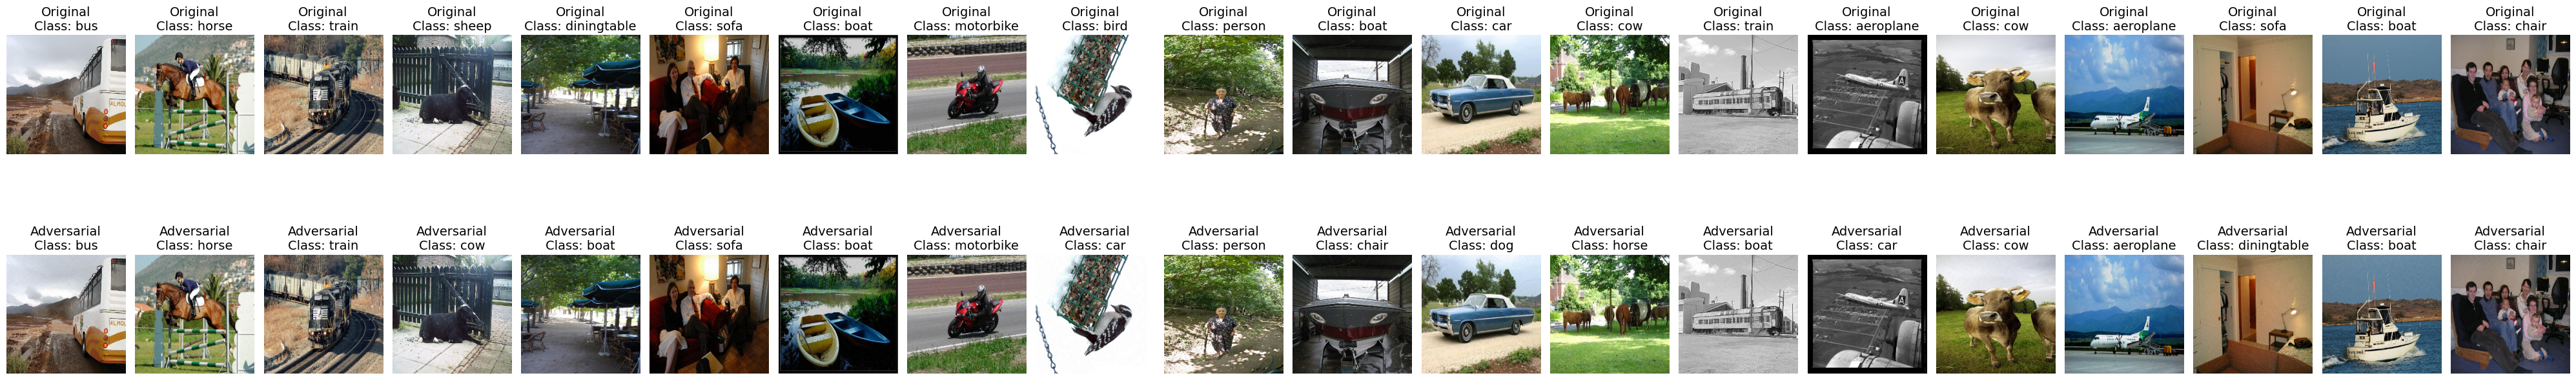

In [116]:
def display_images_with_predictions(model, original_images, adversarial_images, class_names, num_images=5):
    plt.figure(figsize=(40, 8))
    for i in range(num_images):
        # Original image
        original_prediction = model.predict(np.expand_dims(original_images[i], axis=0))
        original_class_index = np.argmax(original_prediction)
        original_class_name = class_names[original_class_index]
        
        plt.subplot(2, num_images, i+1)
        plt.imshow(original_images[i])
        plt.title(f"Original\nClass: {original_class_name}", fontsize=14)
        plt.axis('off')
        
        # Adversarial image
        adversarial_prediction = model.predict(np.expand_dims(adversarial_images[i], axis=0))
        adversarial_class_index = np.argmax(adversarial_prediction)
        adversarial_class_name = class_names[adversarial_class_index]
        
        plt.subplot(2, num_images, i+1+num_images)
        plt.imshow(adversarial_images[i])
        plt.title(f"Adversarial\nClass: {adversarial_class_name}", fontsize=14)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

display_images_with_predictions(model, images, adversarial_images,class_names=class_names, num_images=20)